# PDE Modelling 

## Objectives 
* Make a model that describes cell growth and signalling at the scale of colonies 

## Model considerations 
* Species
    1. Cell density 
    1. Nutrient density 
    1. Environmental AHL (considered equal to intracellular concentration)
    1. Synthase / GFP
    1. Repressor or degradase
* Reactions 
    1. cell growth and diffusion 
        * Cells diffuse very slowly
        * nutrient-dependent growth (from Liu et al 2011, Science) 
        $$  $$ 
    1. Transcriptional activation
        * Basal protein expression -> scaled by repression? probably
        * Activation by internal AHL 
        * Use Hill function $$H(A(t), n, k) = \frac{A(t)^2}{k^n + A(t)^n}$$
        * Activation term, with basal expression and expression rate x
        $$X(A(t), n, k, b, x) = x\frac{A(t)^2}{k^n + A(t)^n} + b$$
    1. Transcriptional repression
        * Assume activation is AND-like, meaning that repression trumps activation
        * Use 'repression' Hill function $$H_n(R(t), n, k) = \frac{k^n}{k^n + R(t)^n}$$
        * Rather than considering protein concentrations within cells, calculate protein concentrations as produced by the bulk of cells. Expression is therefore proportional to cell density.
    1. Dilution and degradation 
        * Assume that GFP/Synthase proteins are degradation tagged
        * Degradase is not tagged, so does not have a degradation term
    1. Diffusion 
        * Here, you're going to use convoultion of the diffusion kernel
        * Diffusion in/out of cell is considered faster than spatial diffusion at these scales
    1. Parameters
        * We are also assuming, for the moment, that each time point is 6 minutes. Parameters with time dimensions shown below may use different units than the parameter from the cited paper.
        * dx: Length modification of diffusion terms. In the compartmental model, diffusion is calculated via Ficks' first law, where the flux between two adjacent compartments is equal to the flux multiplied by the area of the interface between the components :  
        $\frac{\mathrm{d} C}{\mathrm{d} t} $ 
        in continuous form gives up 
        $\Delta C = D \frac{A}{V} \frac{\Delta C}{\Delta x} = D \frac{2.25 \cdot 5 \cdot \mathrm{scale}^2 \mathrm{mm}^2}{\mathrm{scale} \cdot 2.25^2 \cdot 5 \mathrm{mm}^3} \frac{\Delta C \cdot \mathrm{scale}}{2.25 \mathrm{mm}} = \frac{D \Delta C \mathrm{scale}^2}{2.25^2 \mathrm{mm}^2}$. the dx parameter below is the symbol $A$ in this equation.
        * Dc : Diffusion rate for cells. $7\frac{mm^2}{min}$
        * rc : Division rate of cells. $\frac{1.14}{min}$
        * Kn : Half-point of nutrient availability. 75
        * Dn : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * kn : Consumption rate of nutrient by cells
        * Da : Diffusion rate of nutrient. $28\frac{mm^2}{min}$
        * xa : Synthesis rate of AHL. 
        * xs : Expression rate of protein. 
        * ha : Hill coefficient of AHL-inducible expression.
        * ka : Half-point of AHL-inducible expression. 
        * pa : Degradation rate of AHL.
        * leak : Leaky expression rate of protein. 
        


In [1]:
# imports
from __future__ import division, print_function
import numpy as np
import pandas as pd
import os
import sys
import string
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.ndimage as ndi
import matplotlib.pyplot as plt 
import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

%load_ext line_profiler

from IPython.display import HTML

%matplotlib inline

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Helper functions used to define the arenas 
### Needs
* read excel or csv files 
* rescaling arrays and contents 
* convert row/col to array index


* disk function, projects circular areas onto an input grid 
* 

In [2]:
# Universal constants
species = 6
scale_s = 1
rtol = 1e-3
col_thresh = 0.01
cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)
cell_inds = [cs_i, cp_i]
ahl_inds = [a_i]
syn_inds = [r_i]


def disk(A, center, radius):
    h, w = A.shape
    ind_mat = np.zeros((h, w, 2))
    cx, cy = center
    for i in range(h):
        ind_mat[i,:,0] = np.power(np.arange(w) - cx, 2)
    
    for i in range(w):
        ind_mat[:,i,1] = np.power(np.arange(h) - cy, 2)
    
    outmat = (ind_mat[:,:,0] + ind_mat[:,:,1]) < radius**2
    return outmat

# units : L = mm, T = minutes, concentration in nM = moles / mm^3
# Da = 6 - 1.2 E-2
#LEGACY
# Params :    dx,                          Dc,    rc,   Kn,   Dn,   kn,  Da,  xa,  xs,  ha,  ka, 
#p0 = np.array([np.power((scale/2.25),2),   1e-4, 6e-3, 75,  8e-3,  2, 8e-2, 1e3, 2e-0, 2.3, 40,    
          # pa,   leak   od0
#             5e-5, 1e-8, 0.5], dtype=np.float32)



#@numba.jit('void(float32[:,:,:],float32[:,:,:])', nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def calc_diffusion(A, D):
    # Middle
    D[:,1:-1,1:-1] = A[:,1:-1, 2:] + A[:,1:-1, :-2] + A[:,:-2, 1:-1] + A[:,2:, 1:-1] - 4*A[:,1:-1, 1:-1]
    # Edges
    D[:,0,1:-1] = A[:,0, 2:] + A[:,0, :-2] + A[:,1, 1:-1] - 3*A[:,0, 1:-1]
    D[:,-1,1:-1] = A[:,-1, 2:] + A[:,-1, :-2] + A[:,-2, 1:-1] - 3*A[:,-1, 1:-1]
    D[:,1:-1,0] = A[:,2:,0] + A[:,:-2,0] + A[:,1:-1,1] - 3*A[:,1:-1,0]
    D[:,1:-1,-1] = A[:,2:,-1] + A[:,:-2,-1] + A[:,1:-1,-2] - 3*A[:,1:-1,-1]
    # Corners
    D[:,0,0] = A[:,0,1] + A[:,1,0] - 2*A[:,0,0]
    D[:,-1,0] = A[:,-1,1] + A[:,-2,0] - 2*A[:,-1,0]
    D[:,0,-1] = A[:,0,-2] + A[:,1,-1] - 2*A[:,0,-1]
    D[:,-1,-1] = A[:,-1,-2] + A[:,-2,-1] - 2*A[:,-1,-1]

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hill(a, n, k):
    h_ma = 1 - (1 / (1 + (a/k)**n))
    return h_ma

#@numba.jit('float32[:,:](float32[:,:],float32,float32)',nopython=True, cache=True)
@numba.jit(nopython=True, cache=True)
def hillN(a, n, k):
    return 1 / (1 + (a/k)**n)

#@numba.jit('void(float32[:,:,:],float32[:,:,:],float32[:,:,:],float32[:,:])',nopython=True, cache=True)
# @numba.jit(nopython=True, cache=True)
@numba.jit(cache=True)
def calc_f(y, d_y, diff_terms, nut_avail, p0):
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hR, kR, hC, kC, pa, leak, od = p0
    calc_diffusion(y, diff_terms)
    
    # Growth term
    nut_avail[:] = hill(y[n_i,:,:], 2.5, Kn)
    
    # Cell growth and diffusion
    for ind in cell_inds:
        d_y[ind,:,:] = (dx)*Dc*diff_terms[ind,:,:] + rc * nut_avail * y[ind,:,:]
    
    # Nutrient consumption
    d_y[n_i,:,:] = (dx)*Dn*diff_terms[n_i,:,:] - kn * nut_avail * (y[cs_i,:,:] + y[cp_i,:,:])
    
    # AHL production
    for cell_i in cell_inds:
        d_y[a_i,:,:] = (dx)*Da*diff_terms[a_i,:,:] + xa * y[s_i,:,:]*y[cell_i,:,:] - pa * y[a_i,:,:]
    
    # Synthase production
    d_y[s_i,:,:] = (
        xs * np.greater(y[cp_i,:,:],col_thresh) * hill(y[a_i,:,:], hR, kR) * hillN(y[r_i,:,:], hC, kC) + 
        xS * np.greater(y[cs_i,:,:],col_thresh) - 
        rc * y[s_i,:,:]
        ) * nut_avail - rp * y[s_i,:,:]
    
    # Repressor production
    d_y[r_i,:,:] = (
        xr * np.greater(y[cp_i,:,:],col_thresh) * hill(y[a_i,:,:], hR, kR) -
        rc * y[r_i,:,:]
        ) * nut_avail - rp * y[r_i,:,:]

@numba.jit
def f_ivp(t, y, d_y, diff_terms, nut_avail, p0):
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hR, kR, hC, kC, pa, leak, od = p0
    y.shape = (species, n_h, n_w)
    calc_f(y, d_y, diff_terms, nut_avail, p0)
    
    return d_y.flatten()


In [3]:
def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hR, kR, hC, kC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
#         A[ind,:,:] += cell_arr
        A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A


def sim_omnitray(dims, p0, tmax, initial_array, atol): 
    species, n_h, n_w = dims
    args=(np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape, dtype=np.float32,order='C'), 
          np.zeros(initial_array.shape[1:], dtype=np.float32,order='C'), 
          p0)
    initial_array.shape = n_h*n_w*species
    print('Starting')
    f_lambda = lambda t, y : f_ivp(t, y, *args)
    out = itg.solve_ivp(f_lambda, [0, tmax], initial_array, vectorized=True, method='RK23', 
                        atol=atol, rtol=rtol)#, t_eval=np.arange(tmax))
    print('DONE')
    return out


def wrapper(p, atol):
    cs_spots, cp_spots, ahl_spots, p0, dims = p
    dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hR, kR, hC, kC, pa, leak, od = p0
    species, n_h, n_w = dims
    initial_array = np.zeros((species, n_h, n_w), dtype=np.float32, order='C')# + 1e-7
    initial_array[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)
    initial_array = prep_initial_condition(cs_spots, cp_spots, [], dims,p0, A=initial_array)
    out = sim_omnitray(dims, p0, initial_array=initial_array, tmax=10*60, atol=atol)
    exp_t = out.t
    exp_y = out.y.T
    exp_y.shape = (len(exp_t), species, n_h, n_w)
    return exp_y, exp_t
    
def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    plt.close('all')
    
    frames, s, h, w = out.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([n_h, n_w])
    fig, axs = plt.subplots(3,2, figsize=(10,8))
    im_list = [0,0,0,0,0,0,0]
    
    # Plot cell densities
    ax = axs[0,0]
    indxs = [cs_i, cp_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[0] = im
    
    # Plot nutrient densities
    ax = axs[0,1]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[1] = im
    
    # Plot synthase densities
    ax = axs[1,0]
    indxs = [s_i]
    v_arr = im_arr[:,indxs,:,n_w//2:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[2] = im
    
    # Plot AHL densities
    ax = axs[1,1]
    indxs = [a_i]
    v_arr = im_arr[-10,indxs,:,n_w//2:].sum(axis=0)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('AHLs')
    im_list[3] = im
    
    # Plot colony masks
    ax = axs[2,0]
    indxs = [cs_i, cp_i]
    vmax = 50
    vmin = 0
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('masks')
    im_list[4] = im
    
    # Plot represors masks
    ax = axs[2,1]
    indxs = [r_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=4)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('repressors')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0,0]
        indxs = [cs_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[0,1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1,0]
        indxs = [s_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)

        # Plot ahl densities
        ax = axs[1,1]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot colony masks
        ax = axs[2,0]
        indxs = [cs_i, cp_i]
        frame_arr = im_arr[i, indxs, :, :].sum(axis=0) > col_thresh
        frame_arr[:,:np.int(n_w/2)] = 0
        mask, labls = skimage.measure.label(frame_arr,return_num=True, connectivity=1) 
        im_list[4].set_array(mask)
        
        # Plot repressors 
        ax = axs[2,1]
        indxs = [r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[5].set_array(frame_arr)
        
        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

    #anim.save('animation_{}.mp4'.format(fn), writer=writer)
    plt.close('all')
    return anim
    #HTML(anim.to_html5_video())


# Take a look at one frame
out.resize((t_points,species,n_h,n_w))

print(out.shape)

plt.close('all')
fig, axs = plt.subplots(1,species, figsize=(19,5))
for i in np.arange(species):
    ax = axs[i]
    img = ax.imshow(out[-1,i,:,:], interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    cbar = fig.colorbar(mappable=img, ax=ax)
plt.show()

t_i = np.arange(im_t)[colony_mean[:,0].max() == colony_mean[:,0]]
masks, ls = skimage.measure.label(
    np.logical_xor(im_arr[t_i, 0, :, :] > 0.12, 
                   im_arr[t_i, 1, :, :] > 0.12), 
    connectivity=1, 
    return_num=True)
labels_vec[t_i] = labels
plt.imshow(masks[0])
print(ls)

In [7]:
def sim(n_h, n_w, p0):
    col_thresh = 0.05
    tmax=1000
    species = 6 # s_cells, p_cells, nutrients, AHL, synthase, repressor
    dims = np.array([species, n_h, n_w])
    tup = np.array([species, n_h, n_w])
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(species)

    cell_inds = [cs_i, cp_i]
    ahl_inds = [a_i]
    syn_inds = [r_i]

    # Make empty array, and tolerance arrays
    atol = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7
    A = np.zeros((species, n_h, n_w), dtype=np.float32,order='C')# + 1e-7

    # set tolerances
    atol[cs_i,:,:] = 1e-4*np.ones((n_h, n_w), dtype=np.float32)
    atol[cp_i,:,:] = 1e-4*np.ones((n_h, n_w), dtype=np.float32)
    atol[n_i,:,:]  = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
    atol[a_i,:,:]  = 1e-1*np.ones((n_h, n_w), dtype=np.float32)
    atol[s_i,:,:]  = 1e-5*np.ones((n_h, n_w), dtype=np.float32)
    atol[r_i,:,:]  = 1e-5*np.ones((n_h, n_w), dtype=np.float32)

    atol.shape = species*n_h*n_w

    rtol = 1e-3

    # Set initial conditions
    # Nutrients. All at 100
    A[n_i,:,:] = 100*np.ones((n_h, n_w), dtype=np.float32)

    dest_wells = []
    skip = 3
    sender_spots = np.array([(i,j) for i in np.arange(0,n_w//4) for j in np.arange(0,n_h)])
    # sender_spots = sender_spots[np.random.choice(len(sender_spots), len(sender_spots))]
    dest_wells.append(sender_spots)
    receiver_spots = np.array([(i,j) for i in np.arange(0,n_w) for j in np.arange(0,n_h)])
    # receiver_spots = receiver_spots[np.random.choice(len(receiver_spots), len(receiver_spots))]
    dest_wells.append(receiver_spots)

    ahl_centers = []
    # ahl_centers = [(n_w//2, 3*n_h//9)]

    fn_inputs = dest_wells + [ahl_centers, p0, dims]

    a_out = wrapper(fn_inputs, atol)
    return a_out
    
scale = 5
species = 6
# Params :    ,           dx               Dc,    rc,  rp,   Kn,   Dn,  kn,  Da,  xa,    xs,  xS,
p0 = np.array([np.power((scale/4.5),2),   1e-4, 8e-3,  1e-2, 80,  3e-2,  3, 3e-2, 8e-2, 2e2, 2e2, 
#xr,  ha, ka,  hC,  kC,  pa,  leak   od0
3e2, 2.3, 40, 2.3, 400, 5e-3, 1e-8, 0.1], dtype=np.float32)

# Change parameter values above. The function definitions inherit the parameter values defined here.
dx, Dc,  rc, rp,    Kn,  Dn,   kn, Da, xa, xs, xS, xr, hR, kR, hC, kC, pa, leak, od0 = p0
cols = ('scale','n_h','n_w','dx','Dc','rc','rp','Kn','Dn','kn','Da','xa','xs','xS','xr','hR','kR',
        'hC','kC','pa','leak','od0')
parm_df = pd.DataFrame(columns=cols)
scale = 10
out_list = []
var_list = ["xs", 'xa', 'od0']
i = 0
for xs in [0, 2e2]:
    for xa in [np.power(10,x) for x in np.linspace(-3, -1, 4)]:
        for od0 in [np.power(10,x) for x in np.linspace(0, -2, 4)]:
            n_w = scale * 4 # 48
            n_h = 2 # 32
            dims = [scale,n_h,n_w]
            dx = np.power((scale/4.5),2)
            p0_list = [dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hR,kR,hC,kC,pa,leak,od0]
            p0 = np.array(p0_list, dtype=np.float32)
            parm_row = pd.DataFrame(np.array([dims + p0_list]),columns=cols, index=[i])
            i += 1
            parm_df = parm_df.append(parm_row)
            out_list.append(sim(n_h, n_w, p0))

# anim = write_movie(out, t_vec, 8) #, out_names[i])
# HTML(anim.to_html5_video())

Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE
Starting
DONE


In [16]:
# fig, axs = plt.subplots(len(out_list),2 + len(var_list),figsize=(10,30))
par_list = ["c0", "c1", "c2"]
fit_df = pd.DataFrame(np.zeros((len(out_list), len(var_list) + 3)), columns=var_list + par_list)
for i, sim_out in enumerate(out_list):
    scale,n_h,n_w,dx,Dc,rc,rp,Kn,Dn,kn,Da,xa,xs,xS,xr,hR,kR,hC,kC,pa,leak,od0 = parm_df.loc[i,:]
    scale,n_h,n_w = [int(x) for x in [scale,n_h,n_w]]
    movie, tvec = sim_out
    arr = movie[:,r_i,:,np.int(scale):].mean(axis=1)
    _, w = arr.shape
    thresh = arr[-1,:].min() + 10 # 250 # skimage.filters.threshold_li(arr)
    above_thresh = arr > thresh
    crossings = np.zeros(w)
    for j in np.arange(w):
        if np.any(above_thresh[:,j]):
            crossings[j] = tvec[above_thresh[:,j]].min()
            
    xvec = np.linspace(1,4,w)
    fit_x = xvec[crossings>0]
    fit_crossings = crossings[crossings>0]
    
    def f_fun(p, x=fit_x):
        c0,c1,c2 = p
        return c0 + c1 * (x)**c2
#         A, lamb = p
#         y_0 = 0
#         return y_0 + A*np.exp(x/lamb)
    
    def f_res(p, x=fit_x):
        c0,c1,c2 = p
        if c1 < 0:
            return np.inf
        if c2 < 0:
            return np.inf
        res = fit_crossings - f_fun(p, x)
        return np.sum(res*res)

    fit_out = opt.minimize(f_res, np.array([0,10,1]))
    fit_p = fit_out.x
    fit_df.loc[i, var_list] = parm_df.loc[i, var_list].values
    fit_df.loc[i, par_list] = fit_out.x
#     for j, c in enumerate(fit_p):
#         axs[j,2].plot(od0, c, 'b.')
#     axs[i,0].plot(tvec, arr)
#     axs[i,0].plot([tvec[0],tvec[-1]], [thresh]*2)
#     axs[i,1].plot(xvec, crossings,'.')
#     axs[i,1].plot(fit_x, f_fun(fit_out.x, fit_x))
#     axs[i,1].set_title("od0: {:.4}".format(od0))
#     axs[i,1].set_ylim([-10,600])
# fig.tight_layout()

/home/jmp/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))
/home/jmp/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:994: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


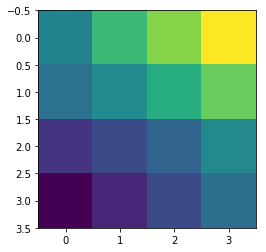

In [26]:
plt.imshow(fit_df[fit_df['xs'].values > 0].pivot(index="xa", columns="od0", values="c2"))

In [21]:
fit_df.columns

Index(['xs', 'xa', 'od0', 'c0', 'c1', 'c2'], dtype='object')